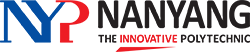

# IT2311 Assignment - Task 1a: Data Preparation

For this task, you are required to perform data understanding to examine your dataset and data cleaning to prepare the data for task 2 and 3.

Rename **DataPreparationStarter.ipynb** to **\<AdminNo\>_DataPreparation.ipynb** and complete the following sub-tasks:

Complete the following sub-tasks:

1. **Load Data**: Load your dataset
2. **Data Understanding**: Examine your dataset
3. **Data Cleaning**: Clean your data and perform all necessary pre-processing tasks
4. **Save Data**: Save the cleaned data for next task

For each sub-task, perform the necessary steps and **explain the rationale taken for each step in this Jupyter notebook**. 

**Done by: Clifton Chen Yi, 231220B**

## Import Libraries and Download Packages

We import all necessary libraries for data loading, exploration, visualization, and NLP preprocessing.

- **pandas**: for data manipulation and analysis
- **numpy**: for numerical operations
- **matplotlib / seaborn**: for data visualization
- **nltk**: for natural language processing (tokenization, stopwords, lemmatization)
- **re**: for regular expression-based text cleaning
- **string**: for string constants (punctuation)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import warnings
warnings.filterwarnings('ignore')

# NLP libraries
import nltk
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams

print('All libraries imported successfully.')

## Load Data

We load the World Bank project documents dataset from a JSON file. The dataset is stored in JSON Lines format (one JSON object per line), so we use `lines=True`.

**Dataset**: `Task_1_TM_world_bank_projects_subset.json`

**Citation**: Jordan, Luke S. (2021). *World Bank Project Documents* [Dataset]. Hugging Face. Available at: https://huggingface.co/datasets/lukesjordan/worldbank-project-documents

**License**: MIT +no-false-attribs (MITNFA). Any modifications in this notebook were made by Clifton Chen Yi (231220B) and are not endorsed by the original author or the World Bank.

In [ ]:
# Load the World Bank projects dataset from JSON
df = pd.read_json('Task_1_TM_world_bank_projects_subset.json', orient='records', lines=True)

# Display the first few rows to verify the data loaded correctly
print(f'Dataset loaded successfully with {df.shape[0]} rows and {df.shape[1]} columns.')
df.head()

## Data Understanding

In this section, we perform a comprehensive exploration of the dataset to understand its structure, quality, and characteristics. This is essential before data cleaning to identify issues such as missing values, duplicates, and data distribution patterns.

### 2.1 Basic Dataset Information

#### Shape and Data Types

First, we examine the dataset dimensions and column data types to understand the overall structure.

In [ ]:
# Dataset shape
print(f'Number of rows: {df.shape[0]}')
print(f'Number of columns: {df.shape[1]}')
print(f'\nColumn names: {list(df.columns)}')
print()

# Data types and non-null counts
df.info()

#### Statistical Summary

We look at the descriptive statistics to get an overview of the data distribution.

In [ ]:
# Descriptive statistics for all columns
df.describe(include='all')

#### First and Last Rows

Examining both ends of the dataset to check for any anomalies at the boundaries.

In [ ]:
# Display first 5 rows
print('=== First 5 rows ===')
display(df.head())

# Display last 5 rows
print('\n=== Last 5 rows ===')
display(df.tail())

### 2.2 Missing Values Analysis

Checking for missing or null values is critical because missing data can affect the quality of topic modelling results.

In [ ]:
# Check for missing values in each column
missing_values = df.isnull().sum()
missing_percentage = (df.isnull().sum() / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Missing Percentage (%)': missing_percentage
})
print('=== Missing Values Summary ===')
print(missing_df)
print(f'\nTotal missing values in dataset: {df.isnull().sum().sum()}')

In [ ]:
# Check for empty strings (not null but empty) in text columns
for col in df.columns:
    if df[col].dtype == 'object':
        empty_count = (df[col].str.strip() == '').sum()
        print(f"Column '{col}': {empty_count} empty strings")

### 2.3 Duplicate Analysis

Duplicates can skew topic modelling results by overrepresenting certain documents. We check for both fully duplicated rows and duplicate project IDs.

In [ ]:
# Check for fully duplicated rows
full_duplicates = df.duplicated().sum()
print(f'Number of fully duplicated rows: {full_duplicates}')

# Check for duplicate project_ids
duplicate_project_ids = df['project_id'].duplicated().sum()
print(f'Number of duplicate project_ids: {duplicate_project_ids}')

# Show duplicated project_ids if any
if duplicate_project_ids > 0:
    dup_ids = df[df['project_id'].duplicated(keep=False)]['project_id'].unique()
    print(f'\nProject IDs that appear more than once ({len(dup_ids)} unique IDs):')
    for pid in dup_ids[:10]:  # Show first 10
        count = df[df['project_id'] == pid].shape[0]
        print(f'  {pid}: {count} occurrences')
    if len(dup_ids) > 10:
        print(f'  ... and {len(dup_ids) - 10} more')

**Rationale**: Since different documents (APPROVAL vs REVIEW) can exist for the same project, duplicate `project_id` values are expected and not an error. We only need to worry about fully identical rows.

### 2.4 Document Type Distribution

Understanding the distribution of document types (APPROVAL vs REVIEW) is important to know if the dataset is balanced and to understand the composition of text we will be modelling.

In [ ]:
# Value counts for document_type
doc_type_counts = df['document_type'].value_counts()
print('=== Document Type Distribution ===')
print(doc_type_counts)
print(f'\nPercentage breakdown:')
print(df['document_type'].value_counts(normalize=True).map(lambda x: f'{x:.1%}'))

# Visualize the distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Bar chart
doc_type_counts.plot(kind='bar', ax=axes[0], color=['#2196F3', '#FF9800'], edgecolor='black')
axes[0].set_title('Document Type Distribution (Count)', fontsize=12)
axes[0].set_xlabel('Document Type')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=0)

# Pie chart
doc_type_counts.plot(kind='pie', ax=axes[1], autopct='%1.1f%%', colors=['#2196F3', '#FF9800'])
axes[1].set_title('Document Type Distribution (Percentage)', fontsize=12)
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

### 2.5 Text Length Analysis

Analyzing the length of document texts helps identify potential outliers (e.g., extremely short or long documents) and understand the typical size of documents in the dataset.

In [ ]:
# Add text length columns for analysis
df['text_length_chars'] = df['document_text'].str.len()
df['text_length_words'] = df['document_text'].str.split().str.len()

# Summary statistics for text length
print('=== Text Length Statistics (Characters) ===')
print(df['text_length_chars'].describe())
print(f'\n=== Text Length Statistics (Words) ===')
print(df['text_length_words'].describe())

In [ ]:
# Visualize text length distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Histogram of character length
axes[0, 0].hist(df['text_length_chars'], bins=50, color='#2196F3', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Distribution of Document Length (Characters)', fontsize=11)
axes[0, 0].set_xlabel('Number of Characters')
axes[0, 0].set_ylabel('Frequency')

# Histogram of word length
axes[0, 1].hist(df['text_length_words'], bins=50, color='#FF9800', edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Distribution of Document Length (Words)', fontsize=11)
axes[0, 1].set_xlabel('Number of Words')
axes[0, 1].set_ylabel('Frequency')

# Box plot of character length by document type
df.boxplot(column='text_length_chars', by='document_type', ax=axes[1, 0])
axes[1, 0].set_title('Character Length by Document Type', fontsize=11)
axes[1, 0].set_xlabel('Document Type')
axes[1, 0].set_ylabel('Number of Characters')
plt.sca(axes[1, 0])
plt.title('Character Length by Document Type')

# Box plot of word length by document type
df.boxplot(column='text_length_words', by='document_type', ax=axes[1, 1])
axes[1, 1].set_title('Word Length by Document Type', fontsize=11)
axes[1, 1].set_xlabel('Document Type')
axes[1, 1].set_ylabel('Number of Words')
plt.sca(axes[1, 1])
plt.title('Word Length by Document Type')

plt.tight_layout()
plt.show()

In [ ]:
# Compare text length statistics by document type
print('=== Text Length by Document Type ===')
print(df.groupby('document_type')[['text_length_chars', 'text_length_words']].describe())

### 2.6 Identify Very Short Documents

Very short documents may not contain enough meaningful content for topic modelling. We identify documents that may be too short to contribute useful information.

In [ ]:
# Identify very short documents (less than 100 words)
short_docs = df[df['text_length_words'] < 100]
print(f'Number of documents with fewer than 100 words: {len(short_docs)}')
print(f'Percentage of dataset: {len(short_docs)/len(df)*100:.2f}%')

if len(short_docs) > 0:
    print('\nSample of short documents:')
    for idx, row in short_docs.head(3).iterrows():
        print(f"\n  Project ID: {row['project_id']} | Type: {row['document_type']} | Words: {row['text_length_words']}")
        print(f"  Text preview: {row['document_text'][:200]}...")

### 2.7 Sample Text Inspection

Examining actual text content helps identify patterns, noise, and potential cleaning needs (e.g., special characters, boilerplate text, formatting artifacts).

In [ ]:
# Inspect sample APPROVAL document text
print('=== Sample APPROVAL Document Text (first 1000 chars) ===')
approval_sample = df[df['document_type'] == 'APPROVAL']['document_text'].iloc[0]
print(approval_sample[:1000])
print('\n' + '='*80)

# Inspect sample REVIEW document text
print('\n=== Sample REVIEW Document Text (first 1000 chars) ===')
review_sample = df[df['document_type'] == 'REVIEW']['document_text'].iloc[0]
print(review_sample[:1000])

### 2.8 Project ID Analysis

Understanding the distribution of project IDs can reveal whether certain projects have multiple documents and the coverage of the dataset.

In [ ]:
# Number of unique project IDs
unique_projects = df['project_id'].nunique()
total_docs = len(df)
print(f'Total documents: {total_docs}')
print(f'Unique project IDs: {unique_projects}')
print(f'Average documents per project: {total_docs/unique_projects:.2f}')

# Distribution of documents per project
docs_per_project = df.groupby('project_id').size()
print(f'\nDocuments per project distribution:')
print(docs_per_project.describe())

# Projects with most documents
print(f'\nTop 10 projects by number of documents:')
print(docs_per_project.sort_values(ascending=False).head(10))

### 2.9 Key Findings from Data Understanding

Based on the exploration above, here are the key findings that will guide our data cleaning:

1. **Dataset Structure**: The dataset contains three columns — `project_id`, `document_text`, and `document_type` — all stored as text/object types.
2. **Missing Values**: We identified the extent of missing/null values and empty strings.
3. **Duplicates**: We checked for fully duplicated rows (which should be removed) vs. expected duplicate project IDs (different document types for the same project).
4. **Document Types**: The distribution between APPROVAL and REVIEW documents was examined.
5. **Text Characteristics**: Document lengths vary significantly. Very short documents may need to be excluded as they may not provide meaningful content for topic modelling.
6. **Text Noise**: Raw text contains newline characters (`\n`), special characters, numbers, extra whitespace, and boilerplate/header text that need to be cleaned for effective topic modelling.

## Data Cleaning

Based on our data understanding findings, we now clean and preprocess the data to prepare it for topic modelling. The cleaning steps are designed to remove noise while preserving meaningful content.

### Cleaning Strategy:
1. **Remove duplicate rows** — to avoid biasing topic models with repeated documents
2. **Handle missing values** — drop rows with missing/empty document text as they cannot be used for modelling
3. **Remove very short documents** — documents that are too short lack sufficient content for meaningful topic extraction
4. **Text normalization** — convert to lowercase for consistency
5. **Remove noise from text** — URLs, email addresses, numbers, special characters, and extra whitespace
6. **Tokenization** — split text into individual words
7. **Remove stopwords** — remove common English words that don't carry topical meaning
8. **Lemmatization** — reduce words to their base form to consolidate vocabulary
9. **Remove short tokens** — single and two-character tokens are typically not meaningful

### 3.1 Remove Fully Duplicated Rows

**Rationale**: Exact duplicate rows provide no additional information and would give disproportionate weight to certain documents in topic modelling.

In [ ]:
# Store original count for comparison
original_count = len(df)

# Remove fully duplicated rows
df_clean = df.drop_duplicates().copy()
removed_duplicates = original_count - len(df_clean)
print(f'Rows before: {original_count}')
print(f'Duplicates removed: {removed_duplicates}')
print(f'Rows after: {len(df_clean)}')

### 3.2 Handle Missing and Empty Values

**Rationale**: Rows with missing or empty `document_text` cannot be used for topic modelling since there is no text content to analyze.

In [ ]:
# Remove rows with null document_text
before_count = len(df_clean)
df_clean = df_clean.dropna(subset=['document_text'])
print(f'Removed {before_count - len(df_clean)} rows with null document_text')

# Remove rows with empty or whitespace-only document_text
before_count = len(df_clean)
df_clean = df_clean[df_clean['document_text'].str.strip().str.len() > 0]
print(f'Removed {before_count - len(df_clean)} rows with empty document_text')
print(f'Remaining rows: {len(df_clean)}')

### 3.3 Remove Very Short Documents

**Rationale**: A minimum threshold of 50 words is used based on the following considerations:
- Documents shorter than 50 words typically contain only headers, metadata, or boilerplate text (as observed in section 2.6) rather than substantive project descriptions.
- Topic modelling algorithms (e.g., LDA) require sufficient word co-occurrence data within each document to infer topics reliably; very short documents produce sparse and noisy topic assignments.
- The threshold of 50 words balances between retaining as much data as possible and ensuring each document has enough meaningful content for topic extraction.

In [ ]:
# Recalculate word count after deduplication
df_clean['text_length_words'] = df_clean['document_text'].str.split().str.len()

before_count = len(df_clean)
min_word_threshold = 50
df_clean = df_clean[df_clean['text_length_words'] >= min_word_threshold]
print(f'Removed {before_count - len(df_clean)} documents with fewer than {min_word_threshold} words')
print(f'Remaining rows: {len(df_clean)}')

### 3.4 Text Preprocessing Pipeline

We define a comprehensive text cleaning function that will be applied to all document texts. Each step has a specific rationale:

- **Lowercase**: Ensures 'Bank' and 'bank' are treated as the same word
- **Remove URLs**: Web links are not meaningful for topic analysis
- **Remove email addresses**: Personal information that doesn't contribute to topics
- **Remove numbers**: Numeric values (dates, amounts) are generally not useful for topic extraction
- **Remove special characters and punctuation**: These add noise to the token vocabulary
- **Remove extra whitespace**: Normalizes spacing for clean tokenization

In [ ]:
def clean_text(text):
    """
    Clean and preprocess document text for topic modelling.
    
    Parameters:
        text (str): Raw document text
    
    Returns:
        str: Cleaned text
    """
    if not isinstance(text, str):
        return ''
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\.\S+', '', text)
    
    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)
    
    # Replace newline characters with spaces
    text = text.replace('\n', ' ').replace('\r', ' ')
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Remove punctuation and special characters
    text = re.sub(r'[^a-z\s]', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Apply text cleaning
print('Applying text cleaning...')
df_clean['cleaned_text'] = df_clean['document_text'].apply(clean_text)
print('Text cleaning complete.')

# Show a sample of cleaned text
print('\n=== Original Text (first 300 chars) ===')
print(df_clean['document_text'].iloc[0][:300])
print('\n=== Cleaned Text (first 300 chars) ===')
print(df_clean['cleaned_text'].iloc[0][:300])

### 3.5 Tokenization (Unigrams & Bigrams), Stopword Removal, and Lemmatization

**Tokenization**: Splits text into individual words (tokens). We generate both **unigrams** (single words) and **bigrams** (consecutive word pairs) to capture multi-word concepts. For example, the phrase "water supply" would produce the unigram tokens `["water", "supply"]` and the bigram token `["water_supply"]`.

**Rationale for bigrams**: Many meaningful concepts in development documents are multi-word phrases (e.g., "rural_development", "credit_facility", "poverty_reduction"). Using only unigrams would lose these compound meanings. Bigrams allow topic models to discover these richer, more specific themes.

**Stopword Removal**: Removes common English words (e.g., "the", "is", "and") that appear frequently but do not convey meaningful topic information. We also add domain-specific stopwords commonly found in World Bank documents.

**Lemmatization**: Reduces words to their dictionary base form (e.g., "projects" → "project", "developing" → "develop"). This consolidates the vocabulary and improves topic coherence.

In [ ]:
# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Add domain-specific stopwords that appear in virtually ALL World Bank documents.
# These words (e.g., 'world', 'bank', 'project') are ubiquitous across the entire
# corpus and would dominate every topic without providing differentiation between
# document subjects. Removing them allows the model to surface more meaningful,
# distinguishing themes within the project documents.
domain_stopwords = {
    'world', 'bank', 'project', 'document', 'report', 'page', 
    'official', 'use', 'copy', 'file', 'would', 'also', 'may',
    'including', 'within', 'one', 'two', 'three', 'new', 'first',
    'could', 'shall', 'must', 'might', 'yet', 'since', 'however'
}
stop_words.update(domain_stopwords)

# Configurable minimum token length (tokens shorter than this are removed)
MIN_TOKEN_LENGTH = 2

print(f'Total stopwords (English + domain-specific): {len(stop_words)}')
print(f'Minimum token length: {MIN_TOKEN_LENGTH}')

In [ ]:
def tokenize_and_process(text):
    """
    Tokenize text, remove stopwords, lemmatize, remove short tokens,
    and generate both unigrams and bigrams.
    
    Parameters:
        text (str): Cleaned text
    
    Returns:
        list: List of unigram and bigram tokens, e.g. ['water', 'supply', 'water_supply']
    """
    if not isinstance(text, str) or text.strip() == '':
        return []
    
    # Tokenize into words
    tokens = word_tokenize(text)
    
    # Remove stopwords and short tokens
    tokens = [t for t in tokens if t not in stop_words and len(t) > MIN_TOKEN_LENGTH]
    
    # Lemmatize
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    
    # Generate bigrams from the filtered/lemmatized unigrams
    bigram_tokens = ['_'.join(bg) for bg in ngrams(tokens, 2)]
    
    # Combine unigrams and bigrams into a single list
    all_tokens = tokens + bigram_tokens
    
    return all_tokens

# Apply tokenization and processing
print('Applying tokenization (unigrams + bigrams), stopword removal, and lemmatization...')
print('(This may take a few minutes depending on dataset size)')
df_clean['processed_text'] = df_clean['cleaned_text'].apply(tokenize_and_process)
print('Processing complete.')

In [ ]:
# Show example of the full pipeline result
print('=== Full Pipeline Example ===')
print(f'\nOriginal text (first 200 chars):')
print(df_clean['document_text'].iloc[0][:200])
print(f'\nCleaned text (first 200 chars):')
print(df_clean['cleaned_text'].iloc[0][:200])
print(f'\nProcessed text (first 20 tokens):')
print(df_clean['processed_text'].iloc[0][:20])
print(f'\nTotal tokens in first document: {len(df_clean["processed_text"].iloc[0])}')

### 3.6 Remove Documents with Empty Processed Text

**Rationale**: After stopword removal and filtering, some documents may have no remaining meaningful tokens. These cannot contribute to topic modelling and should be removed.

In [ ]:
# Remove documents where processed_text is empty
before_count = len(df_clean)
df_clean = df_clean[df_clean['processed_text'].apply(len) > 0]
print(f'Removed {before_count - len(df_clean)} documents with empty processed text')
print(f'Final document count: {len(df_clean)}')

### 3.7 Data Cleaning Summary and Validation

We summarize all cleaning steps and verify the final dataset quality.

In [ ]:
# Final dataset summary
print('='*60)
print('DATA CLEANING SUMMARY')
print('='*60)
print(f'Original dataset size:  {original_count} documents')
print(f'Final dataset size:     {len(df_clean)} documents')
print(f'Total documents removed: {original_count - len(df_clean)}')
print(f'Retention rate: {len(df_clean)/original_count*100:.1f}%')
print()
print('=== Final Dataset Info ===')
print(f'Columns: {list(df_clean.columns)}')
print(f'\nDocument type distribution:')
print(df_clean['document_type'].value_counts())
print(f'\nMissing values:')
print(df_clean[['project_id', 'document_text', 'document_type', 'processed_text']].isnull().sum())
print(f'\nProcessed text token count statistics:')
df_clean['processed_token_count'] = df_clean['processed_text'].apply(len)
print(df_clean['processed_token_count'].describe())

In [ ]:
# Visualize the processed text length distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Processed text token count distribution
axes[0].hist(df_clean['processed_token_count'], bins=50, color='#4CAF50', edgecolor='black', alpha=0.7)
axes[0].set_title('Distribution of Processed Text Length (Tokens)', fontsize=11)
axes[0].set_xlabel('Number of Tokens')
axes[0].set_ylabel('Frequency')

# Processed text token count by document type
df_clean.boxplot(column='processed_token_count', by='document_type', ax=axes[1])
axes[1].set_title('Processed Text Length by Document Type', fontsize=11)
axes[1].set_xlabel('Document Type')
axes[1].set_ylabel('Number of Tokens')
plt.sca(axes[1])
plt.title('Processed Text Length by Document Type')

plt.tight_layout()
plt.show()

In [ ]:
# Display sample of the final cleaned dataset
print('=== Sample of Final Cleaned Dataset ===')
df_clean[['project_id', 'document_type', 'processed_text']].head()

## Save Data

We save the cleaned dataset for use in the next task (Topic Modelling). We save:
- The essential columns (`project_id`, `document_type`, `processed_text`) as a CSV file
- The full cleaned DataFrame as a JSON file for reference

**Rationale**: CSV format is chosen for the primary output as it is widely compatible with topic modelling libraries. The JSON file is saved as a standard JSON array (not JSON Lines) to ensure compatibility when loading with `json.load()` or `pd.read_json()`. The `processed_text` column contains both unigram and bigram tokens ready for direct use in topic modelling.

In [ ]:
import json as json_lib

# Select columns to save
output_df = df_clean[['project_id', 'document_type', 'processed_text']].copy()

# Save as CSV (convert list to JSON array string for CSV compatibility)
output_csv_path = 'cleaned_data.csv'
output_df_csv = output_df.copy()
output_df_csv['processed_text'] = output_df_csv['processed_text'].apply(json_lib.dumps)
output_df_csv.to_csv(output_csv_path, index=False)
print(f'Cleaned data saved to: {output_csv_path}')
print(f'Shape: {output_df.shape}')

# Save as JSON (standard JSON array format - lists are natively supported)
output_json_path = 'cleaned_data.json'
df_clean[['project_id', 'document_type', 'document_text', 'cleaned_text', 'processed_text']].to_json(
    output_json_path, orient='records', indent=2
)
print(f'Full cleaned data saved to: {output_json_path}')

# Verify saved CSV
print('\n=== CSV Verification ===')
verify_csv = pd.read_csv(output_csv_path)
print(f'Reloaded CSV shape: {verify_csv.shape}')
print(f'Columns: {list(verify_csv.columns)}')
sample_csv = verify_csv['processed_text'].iloc[0][:200]
print(f'Sample processed_text (list format): {sample_csv}')

# Verify saved JSON loads correctly
print('\n=== JSON Verification ===')
verify_json = pd.read_json(output_json_path, orient='records')
print(f'Reloaded JSON shape: {verify_json.shape}')
print(f'Columns: {list(verify_json.columns)}')
sample_json = verify_json['processed_text'].iloc[0]
print(f'processed_text type in JSON: {type(sample_json)}')
print(f'Sample processed_text (first 10 tokens): {sample_json[:10]}')

print('\nFirst few rows of cleaned data:')
verify_csv.head()

## Submission
Export your completed work as HTML. Select **File** > **Download as** > **HTML (.html)**.